In [5]:
CONF_THRES=0.1
IOU_THRES=0.1
MODEL_NAME='model_repo/docs/1/model.onnx'

In [6]:
import onnxruntime
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
opt_session = onnxruntime.SessionOptions()
opt_session.enable_mem_pattern = False
opt_session.enable_cpu_mem_arena = False
opt_session.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_DISABLE_ALL

In [8]:
model_path = MODEL_NAME
EP_list = ['CUDAExecutionProvider', 'CPUExecutionProvider']

ort_session = onnxruntime.InferenceSession(model_path, providers=EP_list)

model_inputs = ort_session.get_inputs()
input_names = [model_inputs[i].name for i in range(len(model_inputs))]
input_shape = model_inputs[0].shape
model_output = ort_session.get_outputs()
output_names = [model_output[i].name for i in range(len(model_output))]

c:\Users\65846\anaconda3\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [9]:
output_names

['output0', '1716']

In [10]:
image = cv2.imread('a.jpg')
image_height, image_width = image.shape[:2]
Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

input_height, input_width = input_shape[2:]
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized = cv2.resize(image_rgb, (input_width, input_height))

# Scale input pixel value to 0 to 1
input_image = resized / 255.0
input_image = input_image.transpose(2,0,1)
input_tensor = input_image[np.newaxis, :, :, :].astype(np.float32)
input_tensor.shape

(1, 3, 736, 736)

In [11]:
outputs = ort_session.run(output_names, {input_names[0]: input_tensor})[0]
predictions = np.squeeze(outputs).T
# Filter out object confidence scores below threshold
scores = np.max(predictions[:, 4:], axis=1)
predictions = predictions[scores > CONF_THRES, :]
scores = scores[scores > CONF_THRES]  

In [13]:
class_ids = np.argmax(predictions[:, 4:], axis=1)

In [14]:
# Get bounding boxes for each object
boxes = predictions[:, :4]

#rescale box
input_shape = np.array([input_width, input_height, input_width, input_height])
boxes = np.divide(boxes, input_shape, dtype=np.float32)
boxes *= np.array([image_width, image_height, image_width, image_height])
boxes = boxes.astype(np.int32)

In [15]:
def xywh2xyxy(x):
    # Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

In [16]:
def nms(boxes, scores, iou_threshold):
    # Sort by score
    sorted_indices = np.argsort(scores)[::-1]
    keep_boxes = []
    while sorted_indices.size > 0:
        # Pick the last box
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        # Compute IoU of the picked box with the rest
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        # Remove boxes with IoU over the threshold
        keep_indices = np.where(ious < iou_threshold)[0]
        # print(keep_indices.shape, sorted_indices.shape)
        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes

def compute_iou(box, boxes):
    # Compute xmin, ymin, xmax, ymax for both boxes
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    # Compute intersection area
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area

    return iou

# Apply non-maxima suppression to suppress weak, overlapping bounding boxes
indices = nms(xywh2xyxy(boxes), scores, IOU_THRES)

In [17]:
# Define classes 
CLASSES = ['text','title','list-item','table','figure']

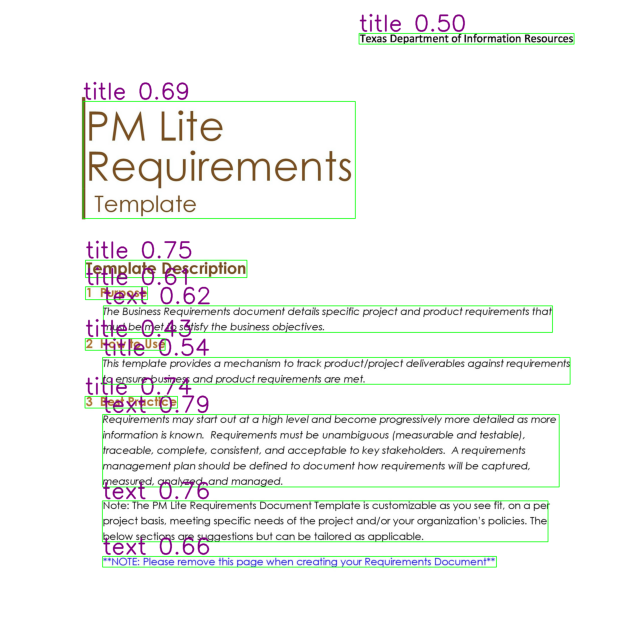

In [18]:
plt.figure(figsize=(8,12))
image_draw = image.copy()
for (bbox, score, label) in zip(xywh2xyxy(boxes[indices]), scores[indices], class_ids[indices]):
    bbox = bbox.round().astype(np.int32).tolist()
    cls_id = int(label)
    cls = CLASSES[cls_id]
    color = (0,255,0)
    cv2.rectangle(image_draw, tuple(bbox[:2]), tuple(bbox[2:]), color, 2)
    cv2.putText(image_draw, cls + ' '+ '{:.2f}'.format(score), (bbox[0],bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 3, (128,0,128), 5)
plt.imshow(image_draw)
plt.axis('off')
plt.show()

CLASS: text
CONTENTS:
Requirements may start out at a high level and become progressively more detailed as more
information is known. Requirements must be unambiguous (measurable and testable),
traceable, complete, consistent, and acceptable to key stakeholders. A requirements
management plan should be defined to document how requirements will be captured,
measured, analyzed, and managed.



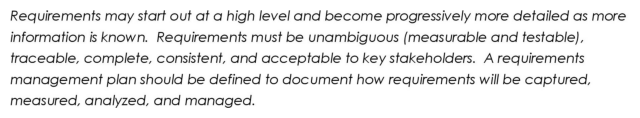

CLASS: text
CONTENTS:
Note: The PM Lite Requirements Document Template is customizable as you see fit, on a pe
project basis, meeting specific needs of the project and/or your organization's policies. The
below sections are suggestions but can be tailored as applicable.



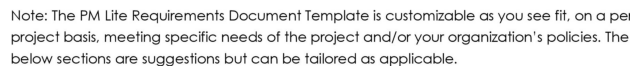

CLASS: title
CONTENTS:
Template Description



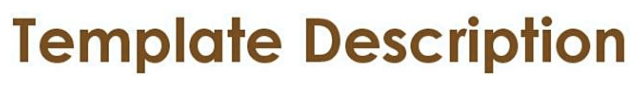

CLASS: title
CONTENTS:
3 Best Practice



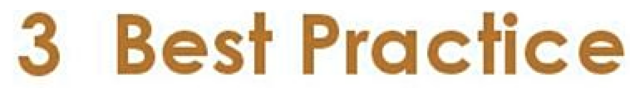

CLASS: title
CONTENTS:
PM Lite
Requirements
Template



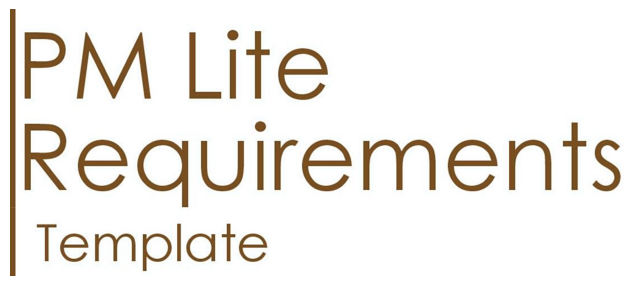

CLASS: text
CONTENTS:
**NIOTE: Please remove this page when creating your Requirements Document**



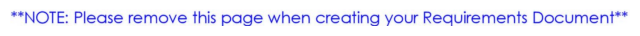

CLASS: text
CONTENTS:
The Business Requirements document details specific project and product requirements that
must be met to satisfy the business objectives.



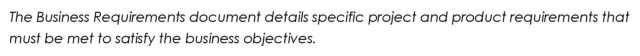

CLASS: title
CONTENTS:
1 Purpose



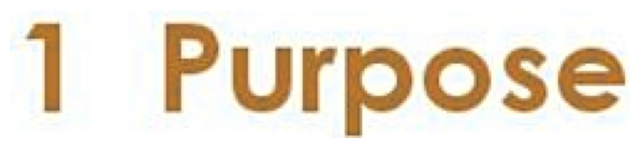

CLASS: title
CONTENTS:
This template provides a mechanism to track product/project deliverables against requirements
to ensure business and product requirements are met.



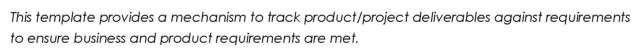

CLASS: title
CONTENTS:
Texas Department of Information Resources



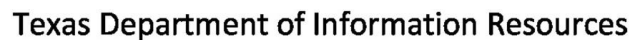

CLASS: title
CONTENTS:
2 How to Use



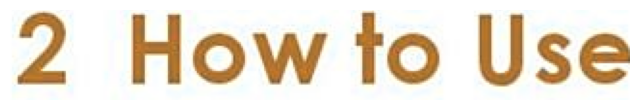

In [22]:
# for ocr with pytesseract
import pytesseract
custom_config = r'--oem 3 --psm 6'
for (bbox, score, label) in zip(xywh2xyxy(boxes[indices]), scores[indices], class_ids[indices]):
    box = bbox.round().astype(np.int32).tolist()
    cls_id = int(label)
    cls = CLASSES[cls_id]
    box_img=image[box[1]:box[3],box[0]:box[2]]
    print('CLASS: '+cls)
    print('CONTENTS:')
    if(cls_id<3):
        print(pytesseract.image_to_string(box_img, config=custom_config, lang='eng'))
    plt.figure(figsize=(8,12))
    plt.imshow(box_img)
    plt.axis('off')
    plt.show()